<a href="https://colab.research.google.com/github/kasettakorn/Machine_Learning/blob/master/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor & Outdoor Scene Recognition

# Loading Dataset from GitHub

In [0]:
!git clone https://github.com/kasettakorn/Machine_Learning.git
!pip install opencv-contrib-python          

In [0]:
import cv2
import os
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

folders = ['Machine_Learning/Datasets/Images/bedroom',
'Machine_Learning/Datasets/Images/bookstore',
'Machine_Learning/Datasets/Images/concert_hall',
'Machine_Learning/Datasets/Images/movietheater',
'Machine_Learning/Datasets/Images/trainstation']
sess = tf.Session()
images = []
labels = []
room_label = []
def load_image_from_folder(folder):
    print(folder)
    room_label.append(folder.split(os.path.sep)[-1])
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, (250,250))
            img = image.img_to_array(img)
            label = folder.split(os.path.sep)[-1]
            labels.append(label)
            images.append(img)
           
        except:
       
            continue

for folder in folders:
    load_image_from_folder(folder)
x = np.array(images)/255
y = np.array(labels)
print(room_label)

In [114]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
y = np.array(onehot_encoded) 
print(y)

[0 0 0 ... 4 4 4]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Random sampling (train_test_split)

In [115]:
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.15, random_state=42)

print("x_train shape = ", x_train.shape)
print("y_train shape = ",y_train.shape)
print("x_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)


x_train shape =  (1252, 250, 250, 3)
y_train shape =  (1252, 5)
x_test shape =  (221, 250, 250, 3)
y_test shape =  (221, 5)


# Convolution Definition

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 82, 82, 32)        0         
_________________________________________________________________
activation_17 (Activation)   (None, 82, 82, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 80, 80, 100)       28900     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 26, 26, 100)       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 24, 24, 68)        61268     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 8, 8, 68)          0         
__________

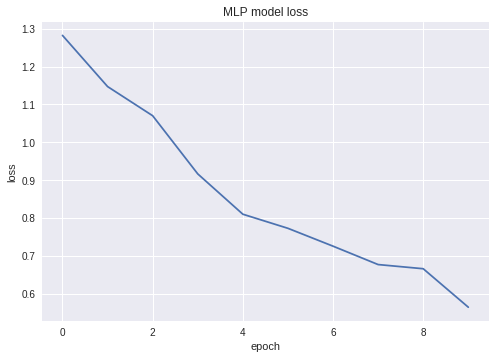

In [121]:
#Convolution-NN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers import BatchNormalization

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), input_shape=(300,300,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))
cnn.add(Activation('relu'))


cnn.add(Conv2D(100, (3, 3) ,activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))


cnn.add(Conv2D(68, (3, 3) ,activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(68, (3, 3) ,activation='relu'))
cnn.add(Conv2D(68, (3, 3) ,activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))


cnn.add(Flatten())
cnn.add(Dense(150, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
print(cnn.summary())


history = cnn.fit(x_train, y_train, epochs=10, batch_size=32)
plt.plot(history.history['loss'])
plt.title('MLP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
#Test Image
result = cnn.predict_classes(x_test, batch_size=32, verbose=0)


**CNN Evaluate**


In [123]:
score = cnn.evaluate(x_test, y_test, verbose=0)
print(cnn.metrics_names)
print(score)

['loss', 'acc']
[0.7628555572949923, 0.7239818985645587]


# ROC Curve

[1 0 0 0 0 1 1 0 1 1]
(221,)
(221, 5)


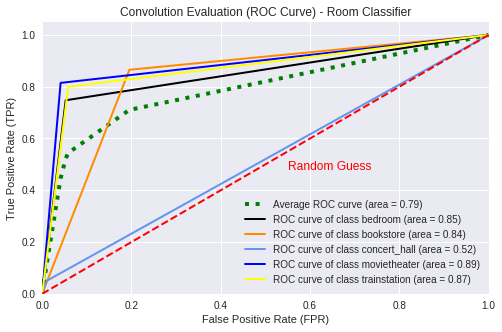

In [124]:
# ROC Curve 
from sklearn.metrics import roc_curve,auc
n_classes=5
pred1=cnn.predict(x_test)
room_label = list(room_label)
fpr = dict()
tpr = dict()
roc_auc = dict()
print(result[:10])
actual = []
for i in range(len(y_test)):
    for j in range(n_classes):
        if y_test[i][j] == 1:
            actual.append(j)
actual = np.array(actual)
print(np.shape(actual))
print(np.shape(pred1))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(actual))[:, i], np.array(pd.get_dummies(result))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['black', 'darkorange', 'cornflowerblue', 'blue', 'yellow'])

for i, color in zip(range(n_classes), colors):
        
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(room_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.55,.48),color='red')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Convolution Evaluation (ROC Curve) - Room Classifier')
plt.legend(loc="lower right")
plt.show()